# Data Pre Processing #

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


df = pd.read_csv("sna_pull_request_metrics.csv")

In [6]:
# drop the text columns
columns=['issue_comments_text', 'review_comments_text', 'reviews_text',
       'issue_text']

df.drop(columns, inplace=True, axis=1)

In [7]:
# drop time_since_last_commit and test_coverage columns
df.drop(['time_since_last_commit', 'test_coverage','dependency_changes', 'number_of_linked_issues', 'number_of_milestones'], axis=1, inplace=True)

#divide review_duration and time to first reponse  by 3600 to get hours
df['review_duration'] = df['review_duration']/3600
df['time_to_first_response'] = df['time_to_first_response']/3600


In [8]:

# Ensure 'comment_authors' is a list
df['comment_authors'] = df['comment_authors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Add a new column to count the number of comment authors
df['num_comment_authors'] = df['comment_authors'].apply(lambda x: len(x) if x else 0)

#if issue has comments fll 'reviewed' with 1 else 0
df['reviewed'] = df['num_comment_authors'].apply(lambda x: 1 if x > 0 else 0)
df['time_to_first_response'] = df['time_to_first_response'].fillna(0)

#drop comment_authors column
df.drop(['comment_authors'], axis=1, inplace=True)


In [9]:
df['code_changes_ratio'] = df['lines_of_code_changed'] / df['number_of_files_changed']

#if code_changes_ratio is nan fill with 0
df['code_changes_ratio'] = df['code_changes_ratio'].fillna(0)


In [10]:
# Function to remove specific prefixes from labels
def remove_prefixes(labels):
    if pd.isna(labels):
        return labels
    prefixes = ['type:', 'scope:', 'platform:', 'status:', 'other:','[',']']
    for prefix in prefixes:
        labels = labels.replace(prefix, '')
    return labels

# Apply the function to the 'Labels' column
df['labels'] = df['labels'].apply(remove_prefixes)

# make a list of all the unique labels
unique_labels = df['labels'].str.split(',').explode().str.strip().unique()

#delete nan
unique_labels = [x for x in unique_labels if str(x) != 'nan']

# add a column for each unique label
for item in unique_labels:
    if isinstance(item, str) and item:
        df[item] = df['labels'].apply(lambda x: 1 if isinstance(x, str) and item in x else 0)

# add a column that counts the number of labels
df['label_count'] = df['labels'].str.split(',').apply(lambda x: len(x) if isinstance(x, list) else 0)

df.drop(['labels'], axis=1, inplace=True)

In [11]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['merged_at'] = pd.to_datetime(df['merged_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['Issue_Lifetime(hours)'] = (df['merged_at'] - df['created_at']).dt.total_seconds() / 3600


# Define the conditions for the 'Issue Lifetime' groups
conditions = [
    (df['Issue_Lifetime(hours)'] < 6),  # less than 6 hours - group 1
    (df['Issue_Lifetime(hours)'] >= 6) & (df['Issue_Lifetime(hours)'] < 48), # between 6 hours and 2 days - group 2
    (df['Issue_Lifetime(hours)'] >= 48) & (df['Issue_Lifetime(hours)'] < 720),  # between 2 days and a month - group 3
    (df['Issue_Lifetime(hours)'] >= 720)  # more than a month - group 4
]

# Define the corresponding group numbers
groups = [1, 2, 3, 4]
group_dict={
    1: 'Less than 6 hours',
    2: 'Between 6 hours and 2 days',
    3: 'Between 2 days and a month',
    4: 'More than a month'
}

# Create the 'Issue Lifetime' column using np.select
df['Issue Lifetime'] = np.select(conditions, groups)

## Data Distribution ##

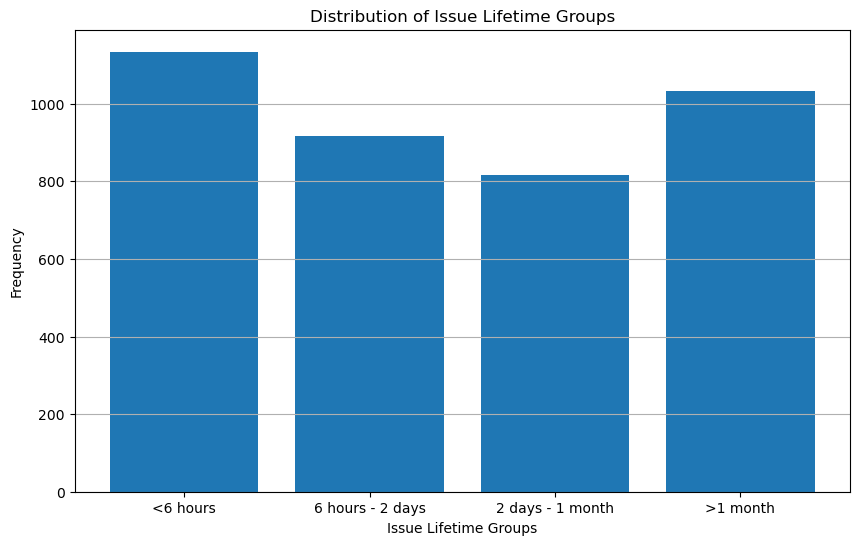

In [12]:
# Graphing the distribution of the groups
group_counts = df['Issue Lifetime'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(group_counts.index, group_counts.values, tick_label=['<6 hours','6 hours - 2 days', '2 days - 1 month', '>1 month'])
plt.title('Distribution of Issue Lifetime Groups')
plt.xlabel('Issue Lifetime Groups')
plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()

In [13]:
# fro each row calcualte how many Issue have been opened since 2 weeks before teh current issue was opened
df['Issues Opened in Last 2 Weeks'] = 0
for i in range(0, len(df)):
    open_date = df['created_at'][i]
    two_weeks_before = open_date - pd.Timedelta(days=14)
    issues_opened = df[(df['created_at'] >= two_weeks_before) & (df['created_at'] < open_date)].shape[0]
    df.loc[i, 'Issues Opened in Last 2 Weeks'] = issues_opened
    
# fro each row calcualte how many Issue have been closed since 2 weeks before teh current issue was opened
df['Issues Closed in Last 2 Weeks'] = 0
for i in range(0, len(df)):
    closed_date = df['merged_at'][i]
    two_weeks_before = closed_date - pd.Timedelta(days=14)
    issues_closed = df[(df['merged_at'] >= two_weeks_before) & (df['merged_at'] < closed_date)].shape[0]
    df.loc[i, 'Issues Closed in Last 2 Weeks'] = issues_closed


# for each row calcualte the nubmer of open pull requests at the time the issue was opened i.e pr merge date is after the open date
df['Open PRs at Open Date'] = 0
for i in range(len(df)):
    open_date = df.loc[i, 'created_at']
    open_prs = df[(df['created_at'] < open_date) & (df['merged_at'] > open_date)].shape[0]
    df.loc[i, 'Open PRs at Open Date'] = open_prs
    


In [14]:
#for each row calcualte how many pull requests were opened before by the author
df['Author PRs Opened'] = 0
for i in range(len(df)):
    author = df.loc[i, 'author']
    author_prs = df[(df['author'] == author) & (df['created_at'] < df['created_at'][i])].shape[0]
    df.loc[i, 'Author PRs Opened'] = author_prs
    
#drop created_at and merged_at columns
df.drop(['created_at', 'merged_at','author'], axis=1, inplace=True)

## Correlation Matrix ##

In [15]:
#calcualte the correlation matrix
correlation_matrix = df.corr()
correlation_matrix


,pr_number,number_of_comments,number_of_review_comments,number_of_commits,lines_of_code_changed,number_of_files_changed,number_of_reviewers,number_of_approvals,time_to_first_response,number_of_assignees,...,' forum',' PR in works',' search',label_count,Issue_Lifetime(hours),Issue Lifetime,Issues Opened in Last 2 Weeks,Issues Closed in Last 2 Weeks,Open PRs at Open Date,Author PRs Opened
pr_number,1.000000,0.064034,0.110415,0.086927,0.042505,0.075658,0.410916,0.444446,-0.567967,-0.087635,...,-0.002973,-0.008738,-0.012499,0.515736,-0.719974,-0.597926,-0.495118,-0.382631,-0.544961,0.456608
number_of_comments,0.064034,1.000000,0.406701,0.336688,0.005192,0.001590,0.291452,0.120262,-0.102621,0.154015,...,0.010709,0.046999,0.020779,0.127600,-0.065204,0.162030,-0.138831,-0.075870,-0.063777,-0.178153
number_of_review_comments,0.110415,0.406701,1.000000,0.443490,-0.001529,-0.002794,0.393607,0.080389,-0.087507,0.192840,...,0.003355,0.000146,0.000127,0.162581,-0.061175,0.159122,-0.123910,-0.090773,-0.053959,-0.118230
number_of_commits,0.086927,0.336688,0.443490,1.000000,0.041702,0.040234,0.182073,0.003064,-0.063878,0.160061,...,0.013557,0.017646,0.008652,0.138344,-0.032344,0.129998,-0.082812,-0.078297,-0.051613,-0.093134
lines_of_code_changed,0.042505,0.005192,-0.001529,0.041702,1.000000,0.748202,0.000896,0.000576,-0.020062,-0.008435,...,-0.001180,0.000160,-0.001434,0.063740,-0.026975,-0.021400,-0.023883,-0.023468,-0.028821,0.026698
number_of_files_changed,0.075658,0.001590,-0.002794,0.040234,0.748202,1.000000,-0.002519,-0.003082,-0.031430,-0.007102,...,-0.001572,0.050987,-0.001883,0.118051,-0.042170,-0.028208,-0.038706,-0.037277,-0.041599,0.064285
number_of_reviewers,0.410916,0.291452,0.393607,0.182073,0.000896,-0.002519,1.000000,0.832193,-0.230442,0.050323,...,0.010801,0.007962,-0.003665,0.297384,-0.299658,-0.178273,-0.334143,-0.176469,-0.322799,0.117969
number_of_approvals,0.444446,0.120262,0.080389,0.003064,0.000576,-0.003082,0.832193,1.000000,-0.223586,-0.033034,...,0.005381,0.016658,-0.019520,0.280463,-0.319144,-0.311962,-0.341033,-0.193898,-0.358188,0.214519
time_to_first_response,-0.567967,-0.102621,-0.087507,-0.063878,-0.020062,-0.031430,-0.230442,-0.223586,1.000000,-0.006864,...,-0.008203,-0.011354,-0.009820,-0.256769,0.741439,0.483275,0.373554,0.322947,0.292644,-0.214050
number_of_assignees,-0.087635,0.154015,0.192840,0.160061,-0.008435,-0.007102,0.050323,-0.033034,-0.006864,1.000000,...,0.045481,0.028653,0.035110,-0.001776,0.022189,0.153935,0.022853,-0.023655,0.094382,-0.091964


# Random Forrest

In [16]:
# Prepare features and target variable
target = df['Issue Lifetime']
features= df.drop(['Issue Lifetime','Issue_Lifetime(hours)'], axis=1)

# Convert categorical features to dummy variables
features = pd.get_dummies(features, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

In [17]:
# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)


Accuracy Score: 0.9038461538461539
Confusion Matrix:
 [[201  15   4   1]
 [ 13 169   7   0]
 [  4  10 145   2]
 [  0   1  18 190]]
Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.91      0.92       221
           2       0.87      0.89      0.88       189
           3       0.83      0.90      0.87       161
           4       0.98      0.91      0.95       209

    accuracy                           0.90       780
   macro avg       0.90      0.90      0.90       780
weighted avg       0.91      0.90      0.90       780

Feature Importances:
 review_duration                  0.278045
pr_number                        0.118694
Issues Opened in Last 2 Weeks    0.077769
Open PRs at Open Date            0.071241
Author PRs Opened                0.061515
time_to_first_response           0.058441
Issues Closed in Last 2 Weeks    0.040165
number_of_commits                0.025754
lines_of_code_changed            0.025016
number_of_

## Getting rid of predictors that have a weak correlation

In [242]:
# Get the correlations with 'review_duration'
review_duration_corr = correlation_matrix['Issue_Lifetime(hours)']

# Define a threshold for strong correlation (e.g., |correlation| > 0.27)
threshold = 0.27

# Filter the correlations that are above the threshold
strong_correlations = review_duration_corr[review_duration_corr.abs() > threshold].sort_values(ascending=False)

# Remove self-correlation
strong_correlations = strong_correlations.drop(labels=['Issue_Lifetime(hours)'])

# Display the strong correlations
print("Strong Correlations with 'Issue_Lifetime(hours)':\n", strong_correlations)

# Extract the columns that have strong correlations
strong_corr_columns = strong_correlations.index.tolist()

# Create a DataFrame with these columns
df_strong_corr = df[strong_corr_columns]

#df_strong_corr

Strong Correlations with 'Issue_Lifetime(hours)':
 time_to_first_response           0.741439
Issue Lifetime                   0.710024
Issues Opened in Last 2 Weeks    0.672048
Open PRs at Open Date            0.514710
Issues Closed in Last 2 Weeks    0.427779
review_duration                  0.400899
number_of_reviewers             -0.299658
Author PRs Opened               -0.312752
number_of_approvals             -0.319144
label_count                     -0.340725
pr_number                       -0.719974
Name: Issue_Lifetime(hours), dtype: float64


## Enhanced Random Forrest ##

In [243]:
target2 = df_strong_corr['Issue Lifetime']

# features should exclude the target variable
features=df_strong_corr.drop(['Issue Lifetime'], axis=1)


# Convert categorical features to dummy variables
features = pd.get_dummies(features, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target2, test_size=0.2, random_state=42)

# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

In [244]:
# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.9205128205128205
Confusion Matrix:
 [[201  15   5   0]
 [  6 170  13   0]
 [  5   5 147   4]
 [  0   0   9 200]]
Classification Report:
               precision    recall  f1-score   support

           1       0.95      0.91      0.93       221
           2       0.89      0.90      0.90       189
           3       0.84      0.91      0.88       161
           4       0.98      0.96      0.97       209

    accuracy                           0.92       780
   macro avg       0.92      0.92      0.92       780
weighted avg       0.92      0.92      0.92       780



In [245]:
# Feature importance
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

Feature Importances:
 review_duration                  0.458775
pr_number                        0.166964
time_to_first_response           0.081749
Issues Opened in Last 2 Weeks    0.078723
Open PRs at Open Date            0.063499
Author PRs Opened                0.059631
Issues Closed in Last 2 Weeks    0.046201
number_of_reviewers              0.023642
number_of_approvals              0.010849
label_count                      0.009968
dtype: float64


# LLM #

In [246]:
X_train.columns

Index(['time_to_first_response', 'Issues Opened in Last 2 Weeks',
       'Open PRs at Open Date', 'Issues Closed in Last 2 Weeks',
       'review_duration', 'number_of_reviewers', 'Author PRs Opened',
       'number_of_approvals', 'label_count', 'pr_number'],
      dtype='object')

In [247]:
import json

# Combine X_train and y_train into a single DataFrame
df_LLM_train = pd.concat([X_train, y_train], axis=1)

# Combine X_test and y_test into a single DataFrame
df_LLM_test = pd.concat([X_test, y_test], axis=1)

In [248]:
# Invoking the API
from openai import OpenAI
#client = OpenAI(api_key = 'openai_api_key')


In [249]:
"""# Open the file in write mode
with open('/Users/atu/Documents/TTS/Final_Attempt/issue_lifetime_data.jsonl', 'w', encoding='utf-8') as f:
    # Iterate over the rows in the DataFrame
    for index, row in df_LLM_train.iterrows():
        # Create the user message by formatting the prompt with the valuea frome each column for each row
        user_message = f"Classify, using ONLY 1 NUMBER between 1 and 4, the following GitHub issue, where 1 is 'Less than 6 hours', 2 is 'Between 6 hours and 2 days', 3 is 'Between 2 days and a month', and 4 is 'More than a month', based on its features: row {str(index)}:\n{row.to_string()}\n"
        
        # Create the assistant message by taking the label
        assistant_message = str(row['Issue Lifetime'])
        
        # Construct the conversation object
        conversation_object = {
            "messages": [
                {"role": "system", "content": "GitHub Issue Lifetime Classifier"},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": assistant_message}
            ]
        }
        
        # Write the conversation object to one line in the file
        f.write(json.dumps(conversation_object, ensure_ascii=False) + '\n') """

'# Open the file in write mode\nwith open(\'/Users/atu/Documents/TTS/Final_Attempt/issue_lifetime_data.jsonl\', \'w\', encoding=\'utf-8\') as f:\n    # Iterate over the rows in the DataFrame\n    for index, row in df_LLM_train.iterrows():\n        # Create the user message by formatting the prompt with the valuea frome each column for each row\n        user_message = f"Classify, using ONLY 1 NUMBER between 1 and 4, the following GitHub issue, where 1 is \'Less than 6 hours\', 2 is \'Between 6 hours and 2 days\', 3 is \'Between 2 days and a month\', and 4 is \'More than a month\', based on its features: row {str(index)}:\n{row.to_string()}\n"\n        \n        # Create the assistant message by taking the label\n        assistant_message = str(row[\'Issue Lifetime\'])\n        \n        # Construct the conversation object\n        conversation_object = {\n            "messages": [\n                {"role": "system", "content": "GitHub Issue Lifetime Classifier"},\n                {"role

## Training the file ##

In [250]:
import json

## Uplopading a training file
'''ft_file = client.files.create(
  file=open("/Users/atu/Documents/TTS/Final_Attempt/issue_lifetime_data.jsonl", "rb"),
  purpose="fine-tune"
)
ft_file '''

'ft_file = client.files.create(\n  file=open("/Users/atu/Documents/TTS/Final_Attempt/issue_lifetime_data.jsonl", "rb"),\n  purpose="fine-tune"\n)\nft_file '

## Model creation ##

In [251]:
## Creating a fine-tuned model
'''ft_job = client.fine_tuning.jobs.create(
  training_file=ft_file.id, 
  model="gpt-3.5-turbo",
  suffix= "git-issueclass"
)

ft_job '''

'ft_job = client.fine_tuning.jobs.create(\n  training_file=ft_file.id, \n  model="gpt-3.5-turbo",\n  suffix= "git-issueclass"\n)\n\nft_job '

In [252]:
'''import openai

# Check the status of the fine-tuning job
fine_tuning_job_id = 'ftjob-6SfxWQgB0V0ZVyz48ARaHwLF'

job_status = client.fine_tuning.jobs.retrieve(fine_tuning_job_id)

if job_status.status == 'succeeded':
    fine_tuned_model = job_status.fine_tuned_model
    print("Fine-tuned model ID:", fine_tuned_model)
elif job_status.status == 'failed':
    print("Fine-tuning job has failed.")
else:
    print("Fine-tuning job has not completed yet.") '''

'import openai\n\n# Check the status of the fine-tuning job\nfine_tuning_job_id = \'ftjob-6SfxWQgB0V0ZVyz48ARaHwLF\'\n\njob_status = client.fine_tuning.jobs.retrieve(fine_tuning_job_id)\n\nif job_status.status == \'succeeded\':\n    fine_tuned_model = job_status.fine_tuned_model\n    print("Fine-tuned model ID:", fine_tuned_model)\nelif job_status.status == \'failed\':\n    print("Fine-tuning job has failed.")\nelse:\n    print("Fine-tuning job has not completed yet.") '

#### ------------------------------------------------------------------------------------------------------------------------------------ ####

In [253]:
# Retrieving the state of a fine-tune
#fine_tuning_job_id = 'ftjob-6SfxWQgB0V0ZVyz48ARaHwLF'

#job_status = client.fine_tuning.jobs.retrieve(fine_tuning_job_id)

#tts_ft_model = client.fine_tuning.jobs.retrieve(fine_tuning_job_id).fine_tuned_model
#print(tts_ft_model)

In [254]:
#client.fine_tuning.jobs.list_events(fine_tuning_job_id=fine_tuning_job_id, limit=20)


## Utilising Fine Tuned Model ##

In [ ]:
#!pip install tiktoken

import openai
import time
import pandas as pd
import re
import concurrent.futures
import tiktoken
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report

openai.api_key ='openai-api-key'

In [ ]:
# max_token here should be one since the class (1,2,3,4) is one token long. 
def query_chatgpt(prompt, model, temperature=0.0,  max_tokens=1, max_retries=5):
    """
    Function to query ChatGPT-4 with a given prompt, with retries for timeouts.

    :param prompt: Prompt string to send to ChatGPT-2.5
    :param model: The model to use, default is ChatGPT-3.5
    :param max_tokens: Maximum number of tokens to generate
    :param max_retries: Maximum number of retries for timeout
    :return: Response from ChatGPT-3.5 or None if all retries fail
    """
    attempt = 0
    max_content_tokens = 3999
    encoding = tiktoken.get_encoding("cl100k_base")
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    # Function to truncate the message and avoid passing the limit of 4k tokens per gpt-3.5 fine-tuned model limitations
    def truncate_message(message, max_length):
        tokens = encoding.encode(message)
        if len(tokens) > max_length:
            truncated_tokens = tokens[:max_length]
            message = encoding.decode(truncated_tokens)
        return message

    # Truncate the prompt if necessary
    prompt = truncate_message(prompt, max_content_tokens)

    while attempt < max_retries:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(
                openai.chat.completions.create,
                model=model,
                messages=[{"role": "system", "content": "GitHub Issue Lifetime Classifier"}, {"role": "user", "content": prompt}],
                max_tokens=max_tokens,
                temperature=temperature
            )
            try:
                response = future.result(timeout=5)  # 5 seconds timeout
                return response.choices[0].message.content
            except concurrent.futures.TimeoutError:
                print(f"Attempt {attempt + 1}/{max_retries} - Request timed out. Retrying...")
            except Exception as e:
                print(f"Attempt {attempt + 1}/{max_retries} - An error occurred: {e}")
            finally:
                attempt += 1

    print("Failed to get a response after several retries.")
    return None
    
labels =[ 1, 2, 3, 4]

In [ ]:
df_LLM_test.shape

(774, 23)

In [ ]:
y_true = []
y_pred = []

iterations = len(df_LLM_test)
lifetime = df_LLM_test['Issue Lifetime']
predictors = df_LLM_test.drop('Issue Lifetime', axis=1)

# Now let's loop through the test data and classify the GitHub issues
for i, row in df_LLM_test.iterrows():
    correct_label = int(row['Issue Lifetime'])  # Access the correct label directly from the row
    description = row.drop('Issue Lifetime').to_string()  # Get the row data as a string
    #description = f"{test_data_facebook.iloc[i]['title']} \n {test_data_facebook.iloc[i]['body']}"
    print(f"Correct PR type: {correct_label}")
    
    #prompt = f"Classify, IN ONLY 1 WORD, the following GitHub issue as 'feature', 'bug', or 'question' based on its title and body:\n{description}"
    prompt = f"Classify, using ONLY 1 NUMBER between 1 and 4, the following GitHub issue, where 1 is 'Less than 6 hours', 2 is 'Between 6 hours and 2 days', 3 is 'Between 2 days and a month', and 4 is 'More than a month', based on its features: row {str(index)}:\n{description}\n"

    response = query_chatgpt(prompt, tts_ft_model)
    
    if response is None:
        print("Failed to get a response after several retries. Skipping this item.")
        continue  # Skip this iteration and move to the next one
    
    # Clean the response to keep only letters (and optionally numbers)
    predicted_label = int(response)
    print(f"Predicted PR Lifetime: {predicted_label}")
    
    # Append to lists for evaluation
    y_true.append(correct_label)
    y_pred.append(predicted_label)
    time.sleep(3)  # Wait for 3 seconds before retrying

Correct PR type: 2
Predicted PR Lifetime: 3
Correct PR type: 1
Predicted PR Lifetime: 2
Correct PR type: 2
Predicted PR Lifetime: 1
Correct PR type: 1
Predicted PR Lifetime: 1
Correct PR type: 2
Predicted PR Lifetime: 1
Correct PR type: 1
Predicted PR Lifetime: 4
Correct PR type: 1
Predicted PR Lifetime: 1
Correct PR type: 3
Predicted PR Lifetime: 2
Correct PR type: 4
Predicted PR Lifetime: 2
Correct PR type: 4
Predicted PR Lifetime: 3
Correct PR type: 4
Predicted PR Lifetime: 3
Correct PR type: 1
Predicted PR Lifetime: 1
Correct PR type: 4
Predicted PR Lifetime: 3
Correct PR type: 4
Predicted PR Lifetime: 3
Correct PR type: 3
Predicted PR Lifetime: 2
Correct PR type: 2
Predicted PR Lifetime: 2
Correct PR type: 2
Predicted PR Lifetime: 3
Correct PR type: 4
Predicted PR Lifetime: 3
Correct PR type: 4
Predicted PR Lifetime: 2
Correct PR type: 3
Predicted PR Lifetime: 1
Correct PR type: 3
Predicted PR Lifetime: 1
Correct PR type: 4
Predicted PR Lifetime: 3
Correct PR type: 2
Predicted PR 

In [ ]:
# Calculate weighted average F1-score, precision, and recall
f1_fb = f1_score(y_true, y_pred, labels=labels, average='weighted')
precision_fb = precision_score(y_true, y_pred, labels=labels, average='weighted')
recall_fb = recall_score(y_true, y_pred, labels=labels, average='weighted')

# Calculate confusion matrix
cm_fb = confusion_matrix(y_true, y_pred, labels=labels)

cm_df_fb = pd.DataFrame(cm_fb, index=labels, columns=labels)

# Calculate TP, FP, FN, TN
results_fb = {}
for i, label in enumerate(labels):
    results_fb[label] = {'TP': cm_fb[i, i]}
    results_fb[label]['FP'] = cm_fb[:, i].sum() - cm_fb[i, i]
    results_fb[label]['FN'] = cm_fb[i, :].sum() - cm_fb[i, i]
    results_fb[label]['TN'] = cm_fb.sum() - (results_fb[label]['TP'] + results_fb[label]['FP'] + results_fb[label]['FN'])

# Print results_fb
for label, metrics in results_fb.items():
    print(f"{label}: {metrics}")

# Save results_fb to CSV
results_fb_df = pd.DataFrame(results_fb).T
results_fb_df['F1-score'] = f1_fb
results_fb_df['Recall'] = recall_fb
results_fb_df['Precision'] = precision_fb

results_fb_df.to_csv('confusion_matrix.csv')

print(f"Precision = {precision_fb}")
print(f"Recall = {recall_fb}")
print(f"F1-score = {f1_fb}")

1: {'TP': 93, 'FP': 286, 'FN': 95, 'TN': 300}
2: {'TP': 52, 'FP': 81, 'FN': 156, 'TN': 485}
3: {'TP': 41, 'FP': 186, 'FN': 109, 'TN': 438}
4: {'TP': 2, 'FP': 33, 'FN': 226, 'TN': 513}
Precision = 0.21650686929436178
Recall = 0.24289405684754523
F1-score = 0.20827207121693858


In [ ]:
# Evaluate the model's predictions
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Add the predictions to the test DataFrame
df_LLM_test['Predicted Issue Lifetime'] = y_pred

# Convert predictions to numeric values if needed
df_LLM_test['Predicted Issue Lifetime'] = pd.to_numeric(df_LLM_test['Predicted Issue Lifetime'], errors='coerce')

# Evaluate the model
print("Accuracy Score:", accuracy_score(df_LLM_test['Issue Lifetime'], df_LLM_test['Predicted Issue Lifetime']))
print("Confusion Matrix:\n", confusion_matrix(df_LLM_test['Issue Lifetime'], df_LLM_test['Predicted Issue Lifetime']))
print("Classification Report:\n", classification_report(df_LLM_test['Issue Lifetime'], df_LLM_test['Predicted Issue Lifetime']))



Accuracy Score: 0.24289405684754523
Confusion Matrix:
 [[ 93  45  28  22]
 [123  52  31   2]
 [ 74  26  41   9]
 [ 89  10 127   2]]
Classification Report:
               precision    recall  f1-score   support

           1       0.25      0.49      0.33       188
           2       0.39      0.25      0.30       208
           3       0.18      0.27      0.22       150
           4       0.06      0.01      0.02       228

    accuracy                           0.24       774
   macro avg       0.22      0.26      0.22       774
weighted avg       0.22      0.24      0.21       774

